# OCR using only CNN


Here we will be only using a CNN to do both segmentation and classification of the charachters found in images. Initially we will only stick to a single font and only written text in that font in an image. Later we can move on to a complex real world scenarios.


## Steps

- First we will generate our dataset for training
- Then we will define our CNN Model
- Train it
- Evaluate and modify if needed

## Initial Steps

### Data Generation

Here we need a function that will generate images contianing random texts with random font-size and thickness. We will use OpenCV for this.

In [1]:
import cv2
import string
import numpy as np
import datetime as dt

In [2]:
def generate_images(data_count, min_char_count=3, max_char_count=8, max_char=16, x_pos='center', image_size=(32, 256, 1), 
                    fonts=[cv2.FONT_HERSHEY_SIMPLEX], font_scale_range=np.arange(0.7, 1, 0.1), thickness_range=range(1,3)):
    """
    Generate images with Random string
    """
    start_time = dt.datetime.now()
    images=[]
    labels=[]
    color=(255,255,255)
    count=0
    char_list = list(string.ascii_letters) + list(string.digits) + list(' ')
    
    while count < data_count:
        for fs in font_scale_range:
            for thickness in thickness_range:
                for font in fonts:
                    img = np.zeros(image_size, np.uint8)
                    random_char_count = np.random.randint(min_char_count, max_char_count+1)
                    random_string = ''.join(np.random.choice(char_list, random_char_count))

                    # generate image out of random_string
                    text_box_size = cv2.getTextSize(random_string, font, fs, thickness)[0]
                    if x_pos != 'center':
                        orig_x = 0
                    else:
                        orig_x = (image_size[1] - text_box_size[0])//2
                    orig_y = (image_size[0] + text_box_size[1])//2
                    cv2.putText(img, random_string, (orig_x, orig_y), font, fs, color, thickness, cv2.LINE_AA)

                    # generate the label for the image
                    # fill the remaining of the positions with spaces
                    label = list(random_string) + [' '] * (max_char - len(random_string))
                    for i, t in enumerate(label):
                        label[i] = char_list.index(t)
                    label = np.uint8(label)
                    images.append(img)
                    labels.append(label)

                    count+=1
                    
                    if count == data_count:
                        end_time = dt.datetime.now()
                        print('Time taken to geneate data is: ', (end_time - start_time))
                        return images, labels
    
    end_time = dt.datetime.now()
    print('Time taken to geneate data is: ', (end_time - start_time))
    return images, labels

In [3]:
data, labels = generate_images(8192, max_char_count=16)

Time taken to geneate data is:  0:00:01.428927


### Visualizing Generated Data

In [4]:
import matplotlib.pyplot as plt

/home/sbjr/my_bin/apps/miniconda3/envs/tf-gpu-2.2/lib/python3.8/site-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


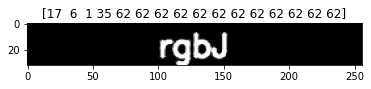

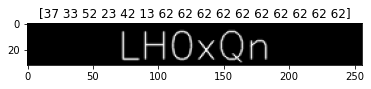

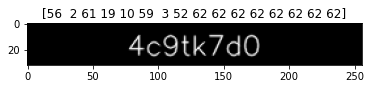

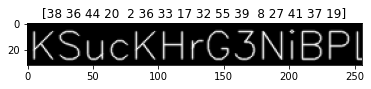

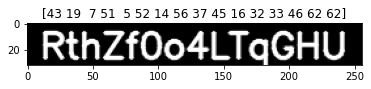

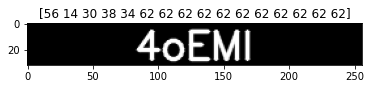

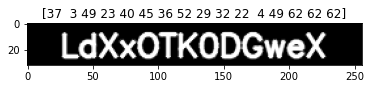

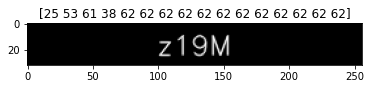

In [5]:
for i in range(8):
    index = np.random.randint(0, len(data))
    plt.title(labels[index])
    plt.imshow(data[index], cmap='gray')
    plt.show()

## The CNN Architecture

Here we will have the ouput of shape 16x63 where 16 specifies that the network has to identify the 16 charachters in a word and the 63 specifies the softmax probabilites of each of the classes that it has to predict for each charachter. This requires us to create a custom loss function so that we can accumulate the loss for each charachter properly and propagate the proper error for back-propagation

### Custom Loss

Here we will take the average of the loss for each charachter.

In [6]:
import tensorflow as tf

In [156]:
categorical_labels = tf.keras.utils.to_categorical(np.array(labels), 63)

In [248]:
print(categorical_labels.shape)

(8192, 16, 63)


In [249]:
def multi_loss(labels, logits):
    """
    cross entropy for multi class
    """
    #print(labels.shape)
    #logits = tf.reshape(logits, (-1, 16, 63))
    #print(logits.shape)
    total_loss = 0.0
    for i in range(16):
        loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits[:,i], labels=labels[:,i], name='cross_entropy_loss_mean') #shape = batch_size
        total_loss = tf.add(total_loss, loss) #shape = batch_size
    mean_loss = tf.divide(tf.reduce_mean(total_loss), 16) #shape = 1
    #tf.Graph.add_to_collection('losses', loss)
    #total_loss = tf.add_n(tf.Graph.get_collection(name='losses'), name='total_loss')
    #tf.Graph.add_to_collection('losses', total_loss)
    #print('Returned loss',mean_loss)
    return mean_loss

### The Model

In [259]:
model = tf.keras.models.Sequential([ # input = 32x256x1
    tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu'), #32x256x16 
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'), #16x128x16
    #tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'), # 16x128x32
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)), #8x64x32
    #tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(63, (3,3), padding='same', activation='relu'), #8x63x63
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'), #4x32x63
    #tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(63, (3,3), padding='same', activation='relu'), #4x32x63
    tf.keras.layers.MaxPool2D(pool_size=(4,2), strides=(1,2)), #1x16x63
    #tf.keras.layers.Dropout(0.2),
    
    #tf.keras.layers.Conv2D(63, (3,3), padding='same', activation='relu'), #2x16x63 
    #tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,1), padding='same'), #1x16x63
    tf.keras.layers.Reshape((16,63))
])

In [260]:
model.compile(loss=multi_loss, optimizer='adam', metrics=['accuracy'])

### The Generator

In [244]:
images = np.array(data)
images = images.reshape((-1, 32, 256, 1))

In [245]:
images.shape

(8192, 32, 256, 1)

In [246]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255
)

generator = datagen.flow(
    images,
    categorical_labels,
    batch_size=256,
)

In [261]:
model.fit(generator, steps_per_epoch=32, epochs=100, verbose=1)

Epoch 1/100
32/32 [==============================] - 2s 60ms/step - loss: 3.7180 - accuracy: 0.3917
Epoch 2/100
32/32 [==============================] - 2s 58ms/step - loss: 3.1377 - accuracy: 0.4128
Epoch 3/100
32/32 [==============================] - 2s 58ms/step - loss: 3.0489 - accuracy: 0.4107
Epoch 4/100
32/32 [==============================] - 2s 58ms/step - loss: 3.0047 - accuracy: 0.4141
Epoch 5/100
32/32 [==============================] - 2s 58ms/step - loss: 2.9867 - accuracy: 0.4102
Epoch 6/100
32/32 [==============================] - 2s 58ms/step - loss: 2.9464 - accuracy: 0.4157
Epoch 7/100
32/32 [==============================] - 2s 59ms/step - loss: 2.9457 - accuracy: 0.4125
Epoch 8/100
32/32 [==============================] - 2s 59ms/step - loss: 2.9402 - accuracy: 0.4127
Epoch 9/100
32/32 [==============================] - 2s 59ms/step - loss: 2.9428 - accuracy: 0.4113
Epoch 10/100
32/32 [==============================] - 2s 59ms/step - loss: 2.9388 - accuracy: 0.4117

KeyboardInterrupt: 

## here we can see that the accuracy never went above 41.26%

## Model2

### Flatten Labels

In [193]:
categorical_labels_flat = np.reshape(categorical_labels, (-1, 1008))
print(categorical_labels_flat.shape)

(8192, 1008)


### Model with Dense Layer

In [225]:
model_v2 = tf.keras.models.Sequential([ # input = 32x256x1
    tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu'), # 32x256x16
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)), #16x128x16
    
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'), #16x128x32 
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)), #8x64x32
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'), #8x64x64 
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)), #4x32x64
    
    #tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'), #4x32x128 
    #tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)), #2x16x128
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(1008, activation='relu')
])

### A new Loss Function

In [226]:
def multi_loss_v2(labels, logits):
    """
    cross entropy for multi class
    """
    #print(labels.shape)
    logits = tf.reshape(logits, (-1, 16, 63))
    labels = tf.reshape(labels, (-1, 16, 63))
    #print(logits.shape)
    total_loss = 0.0
    for i in range(16):
        loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits[:,i], labels=labels[:,i], name='cross_entropy_loss_mean') #shape = batch_size
        total_loss = tf.add(total_loss, loss) #shape = batch_size
    mean_loss = tf.divide(tf.reduce_mean(total_loss), 16) #shape = 1
    #tf.Graph.add_to_collection('losses', loss)
    #total_loss = tf.add_n(tf.Graph.get_collection(name='losses'), name='total_loss')
    #tf.Graph.add_to_collection('losses', total_loss)
    #print('Returned loss',mean_loss)
    return mean_loss

In [227]:
model_v2.compile(loss=multi_loss_v2, optimizer=tf.keras.optimizers.SGD(lr=0.001), metrics=['accuracy'])

In [228]:
datagen_v2 = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255
)

generator_v2 = datagen.flow(
    images,
    categorical_labels_flat,
    batch_size=256,
)

In [229]:
model_v2.fit(generator_v2, steps_per_epoch=32, epochs=100, verbose=1)

Epoch 1/100
32/32 [==============================] - 2s 55ms/step - loss: 4.1434 - accuracy: 9.7656e-04
Epoch 2/100
32/32 [==============================] - 2s 56ms/step - loss: 4.1418 - accuracy: 9.7656e-04
Epoch 3/100
32/32 [==============================] - 2s 56ms/step - loss: 4.1398 - accuracy: 9.7656e-04
Epoch 4/100
 9/32 [=======>......................] - ETA: 1s - loss: 4.1383 - accuracy: 0.0022

KeyboardInterrupt: 